In [1]:
import pandas as pd
import numpy as np
import json
import sys
from sklearn.preprocessing import LabelEncoder   #把字串符號轉數字
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from matplotlib import pyplot as plt
import math

In [2]:
with open('SMP/train_img.txt', 'r') as f:
    imgs = f.read().splitlines()

In [3]:
imageID = []
for i in range(len(imgs)):
    imageID.append(imgs[i].split('/')[-1])
imageID = pd.DataFrame(imageID)
imageID = imageID.rename(columns={0:'imageID'})

In [4]:
imageID.head()

,imageID
0,385070026
1,943750056
2,3246928439
3,3432316502
4,3538960847


In [5]:
label = pd.read_csv("SMP/train_label.txt", header = None) #處理沒有feature name的方式
label = label.rename(columns={0:'score'})
label.head()

,score
0,11.18
1,15.15
2,10.99
3,8.63
4,11.16


In [6]:
imageInformation = pd.read_csv("SMP/image_information.txt",skiprows=[764,767], header = None).astype('int64')
imageInformation = imageInformation.rename(columns={0:'imageID'})
imageInformation = imageInformation.rename(columns={1:'ViewCount'})
imageInformation = imageInformation.rename(columns={2:'FavoriteCount'})
imageInformation = imageInformation.rename(columns={3:'Message'})
imageInformation = imageInformation.reindex(columns=['imageID', 'ViewCount', 'FavoriteCount', 'Message']) #重設置index
imageInformation.head()

,imageID,ViewCount,FavoriteCount,Message
0,943750056,49403,31,32
1,3544891702,21131,41,7
2,3246928439,3455,8,1
3,3432316502,615,1,4
4,3538960847,3980,57,10


In [7]:
with open('SMP/train_tags.json', 'r') as f:
    tags = json.load(f)
tags = pd.DataFrame(tags)
#tags.head()

In [8]:
AllTags = []
for i in range(len(tags['Alltags'])):
    AllTags.append(len(tags['Alltags'][i].split()))

AllTags = pd.DataFrame(AllTags)
AllTags = AllTags.rename(columns={0:'TagsCount'})

In [9]:
AllTags.head()

,TagsCount
0,12
1,65
2,23
3,9
4,19


In [10]:
# with open('SMP/train_temporalspatial.json', 'r') as ff:
#     temporalspatial = json.load(ff)
# temporalspatial = pd.DataFrame(temporalspatial)
# temporalspatial.head()

In [11]:
with open('SMP/train_category.json', 'r') as ff:
    category = json.load(ff)
category = pd.DataFrame(category)
category.head()

,Category,Concept,Pid,Subcategory,Uid
0,Fashion,glam,775,Fashion,59@N75
1,Travel&Active&Sports,fifa,1075,Soccer,1@N18
2,Entertainment,cinema,4890,Movies,351@N64
3,Holiday&Celebrations,old,6568,Birthday,6@N59
4,Food,thirsty,7079,Drinks,1617@N40


In [12]:
#把字串符號轉成數字
Uid = category["Uid"]
Uid = pd.DataFrame(Uid)
Uid["Uid"] = Uid["Uid"].apply(str)
Uid["Uid_code"] = LabelEncoder().fit_transform(Uid["Uid"])
Uid.drop(columns = ["Uid"],inplace=True)
Uid.head()

,Uid_code
0,31775
1,2876
2,14395
3,33828
4,1934


In [13]:
#把字串符號轉成數字
Concept = category["Concept"]
Concept = pd.DataFrame(Concept)
Concept["Concept"] = Concept["Concept"].apply(str)
Concept["Concept_code"] = LabelEncoder().fit_transform(Concept["Concept"])
Concept.drop(columns = ["Concept"],inplace=True)
Concept.head()

,Concept_code
0,254
1,200
2,105
3,426
4,602


In [14]:
# with open('SMP/train_additional.json', 'r') as ff:
#     additional = json.load(ff)
# additional = pd.DataFrame(additional)
# additional.head()

In [15]:
trainData = pd.concat( [imageID , Uid], axis=1 )   # axis=1是X軸，axis=0是y軸
trainData = pd.concat( [trainData , Concept], axis=1 )
trainData = pd.concat( [trainData , AllTags], axis=1 )
trainData = pd.concat( [trainData , label], axis=1 )
trainData.head()

,imageID,Uid_code,Concept_code,TagsCount,score
0,385070026,31775,254,12,11.18
1,943750056,2876,200,65,15.15
2,3246928439,14395,105,23,10.99
3,3432316502,33828,426,9,8.63
4,3538960847,1934,602,19,11.16


In [16]:
trainData["imageID"] = trainData["imageID"].apply(int)
trainData = pd.merge(imageInformation, trainData, how='left', on='imageID')
trainData = trainData[['imageID','Uid_code','Concept_code','ViewCount','FavoriteCount','Message','TagsCount','score']]
trainData.head()

,imageID,Uid_code,Concept_code,ViewCount,FavoriteCount,Message,TagsCount,score
0,943750056,2876.0,200.0,49403,31,32,65.0,15.15
1,3544891702,1934.0,212.0,21131,41,7,37.0,14.24
2,3246928439,14395.0,105.0,3455,8,1,23.0,10.99
3,3432316502,33828.0,426.0,615,1,4,9.0,8.63
4,3538960847,1934.0,602.0,3980,57,10,19.0,11.16


In [17]:
trainData = trainData.drop(['ViewCount','FavoriteCount','Message'], axis=1)
trainData.head()

,imageID,Uid_code,Concept_code,TagsCount,score
0,943750056,2876.0,200.0,65.0,15.15
1,3544891702,1934.0,212.0,37.0,14.24
2,3246928439,14395.0,105.0,23.0,10.99
3,3432316502,33828.0,426.0,9.0,8.63
4,3538960847,1934.0,602.0,19.0,11.16


In [18]:
trainData.shape

(273119, 5)

In [19]:
trainData.dropna(axis=0,inplace=True)   # axis=1是X軸，axis=0是y軸

In [20]:
trainData.shape

(273113, 5)

In [21]:
trainData.isnull().any()

imageID         False
Uid_code        False
Concept_code    False
TagsCount       False
score           False
dtype: bool

In [22]:
with open('SMP/image_object.txt', 'r') as f:
    object = f.read().splitlines()
len(object[0].split(','))

imageID = []
for i in range(len(object)):
    imageID.append(object[i].split(',')[0])
imageID = pd.DataFrame(imageID)
imageID = imageID.rename(columns={0:'imageID'})
imageID.head()

AllObject = []
for i in range(len(object)):
    AllObject.append(len(object[i].split(','))-2)
AllObject = pd.DataFrame(AllObject)
AllObject = AllObject.rename(columns={0:'AllObject'})
AllObject.head()

trainObject = pd.concat( [imageID , AllObject], axis=1 )

trainObject.head()

,imageID,AllObject
0,10033402254,4
1,10074972466,2
2,10119284375,2
3,10137707764,0
4,10138499783,1


In [23]:
trainObject["imageID"] = trainObject["imageID"].apply(int)
trainData = pd.merge(trainObject, trainData, how='left', on='imageID')
trainData.dropna(axis=0,inplace=True)

#trainData = trainData.drop(['AllObject'], axis=1)
trainData.head()

,imageID,AllObject,Uid_code,Concept_code,TagsCount,score
0,10033402254,4,22098.0,0.0,58.0,9.87
1,10074972466,2,30188.0,139.0,27.0,10.56
2,10119284375,2,1125.0,442.0,25.0,10.52
3,10137707764,0,1125.0,442.0,33.0,10.14
4,10138499783,1,1125.0,442.0,19.0,11.70


In [24]:
trainData.shape

(270164, 6)

In [25]:
def pow_square(x):
    return math.pow(x,2)
def pow_cube(x):
    return math.pow(x,3)
def log(x):
    return math.log(10,x)
def pow_squareRoot(x):
    return math.pow(x,1/2.0)

In [26]:
# #trainData['ViewCount'] = trainData["ViewCount"].apply(pow_cube)
# trainData['Concept_code'] = trainData["Concept_code"].apply(pow_square)
# trainData['TagsCount'] = trainData["TagsCount"].apply(pow_squareRoot)
# #trainData['AllObject'] = trainData["AllObject"].apply(pow_squareRoot)
# #trainData['FavoriteCount'] = trainData["FavoriteCount"].apply(pow_squareRoot)
# #trainData['Message'] = trainData["Message"].apply(pow_squareRoot)
# trainData.head()    

In [27]:
# trainData.drop(['Message', 'FavoriteCount', 'AllObject'], axis=1, inplace=True)
# trainData.head()

In [28]:
temp , X_test= train_test_split(trainData, test_size=0.2)
X_train , X_valid = train_test_split(temp,test_size=0.1)
Y_train = X_train["score"]
X_train = X_train.drop(["score"],axis = 1)
Y_test = X_test["score"]
X_test = X_test.drop(["score"],axis = 1)
Y_valid = X_valid["score"]
X_valid = X_valid.drop(["score"],axis = 1)

In [29]:
model = XGBRegressor(
    max_depth=9,
    n_estimators=1000,
    min_child_weight=1, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 15)

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:5.80655	validation_1-rmse:5.81433
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:5.29576	validation_1-rmse:5.30332
[2]	validation_0-rmse:4.84206	validation_1-rmse:4.84901
[3]	validation_0-rmse:4.43982	validation_1-rmse:4.44644
[4]	validation_0-rmse:4.08073	validation_1-rmse:4.08771
[5]	validation_0-rmse:3.76368	validation_1-rmse:3.77089
[6]	validation_0-rmse:3.4857	validation_1-rmse:3.49279
[7]	validation_0-rmse:3.24341	validation_1-rmse:3.25136
[8]	validation_0-rmse:3.03418	validation_1-rmse:3.04294
[9]	validation_0-rmse:2.84393	validation_1-rmse:2.85374
[10]	validation_0-rmse:2.686	validation_1-rmse:2.69676
[11]	validation_0-rmse:2.54968	validation_1-rmse:2.56105
[12]	validation_0-rmse:2.42631	validation_1-rmse:2.43898
[13]	validation_0-rmse:2.32022	validation_1-rmse:2.33382
[14]	validation_0-rmse:2.22866	validation_1-rmse:2.24401

[142]	validation_0-rmse:1.34855	validation_1-rmse:1.4562
[143]	validation_0-rmse:1.34729	validation_1-rmse:1.45531
[144]	validation_0-rmse:1.34538	validation_1-rmse:1.45416
[145]	validation_0-rmse:1.34345	validation_1-rmse:1.45303
[146]	validation_0-rmse:1.34112	validation_1-rmse:1.45143
[147]	validation_0-rmse:1.34051	validation_1-rmse:1.45131
[148]	validation_0-rmse:1.33872	validation_1-rmse:1.45063
[149]	validation_0-rmse:1.33696	validation_1-rmse:1.44929
[150]	validation_0-rmse:1.33592	validation_1-rmse:1.44876
[151]	validation_0-rmse:1.33408	validation_1-rmse:1.4477
[152]	validation_0-rmse:1.33253	validation_1-rmse:1.44669
[153]	validation_0-rmse:1.33075	validation_1-rmse:1.44542
[154]	validation_0-rmse:1.32815	validation_1-rmse:1.44361
[155]	validation_0-rmse:1.32735	validation_1-rmse:1.44328
[156]	validation_0-rmse:1.32416	validation_1-rmse:1.44085
[157]	validation_0-rmse:1.32354	validation_1-rmse:1.44058
[158]	validation_0-rmse:1.32182	validation_1-rmse:1.43959
[159]	validation

[284]	validation_0-rmse:1.1843	validation_1-rmse:1.35444
[285]	validation_0-rmse:1.18389	validation_1-rmse:1.35432
[286]	validation_0-rmse:1.18261	validation_1-rmse:1.35361
[287]	validation_0-rmse:1.18077	validation_1-rmse:1.3527
[288]	validation_0-rmse:1.18015	validation_1-rmse:1.35248
[289]	validation_0-rmse:1.17926	validation_1-rmse:1.35214
[290]	validation_0-rmse:1.17816	validation_1-rmse:1.35173
[291]	validation_0-rmse:1.17793	validation_1-rmse:1.35159
[292]	validation_0-rmse:1.17764	validation_1-rmse:1.35155
[293]	validation_0-rmse:1.17643	validation_1-rmse:1.35088
[294]	validation_0-rmse:1.1762	validation_1-rmse:1.35086
[295]	validation_0-rmse:1.1752	validation_1-rmse:1.35018
[296]	validation_0-rmse:1.17447	validation_1-rmse:1.35004
[297]	validation_0-rmse:1.17323	validation_1-rmse:1.34909
[298]	validation_0-rmse:1.17275	validation_1-rmse:1.34876
[299]	validation_0-rmse:1.17217	validation_1-rmse:1.3485
[300]	validation_0-rmse:1.17117	validation_1-rmse:1.34786
[301]	validation_0-

[426]	validation_0-rmse:1.07248	validation_1-rmse:1.29785
[427]	validation_0-rmse:1.07207	validation_1-rmse:1.2976
[428]	validation_0-rmse:1.07178	validation_1-rmse:1.29749
[429]	validation_0-rmse:1.07103	validation_1-rmse:1.29722
[430]	validation_0-rmse:1.07086	validation_1-rmse:1.29722
[431]	validation_0-rmse:1.07007	validation_1-rmse:1.29692
[432]	validation_0-rmse:1.06908	validation_1-rmse:1.29645
[433]	validation_0-rmse:1.06883	validation_1-rmse:1.29641
[434]	validation_0-rmse:1.06845	validation_1-rmse:1.29623
[435]	validation_0-rmse:1.06727	validation_1-rmse:1.29562
[436]	validation_0-rmse:1.06584	validation_1-rmse:1.29472
[437]	validation_0-rmse:1.06462	validation_1-rmse:1.29411
[438]	validation_0-rmse:1.06423	validation_1-rmse:1.29393
[439]	validation_0-rmse:1.06344	validation_1-rmse:1.29365
[440]	validation_0-rmse:1.06277	validation_1-rmse:1.29326
[441]	validation_0-rmse:1.06176	validation_1-rmse:1.29261
[442]	validation_0-rmse:1.06104	validation_1-rmse:1.29239
[443]	validatio

[568]	validation_0-rmse:0.989275	validation_1-rmse:1.26033
[569]	validation_0-rmse:0.988894	validation_1-rmse:1.26009
[570]	validation_0-rmse:0.988244	validation_1-rmse:1.25975
[571]	validation_0-rmse:0.987983	validation_1-rmse:1.25969
[572]	validation_0-rmse:0.987477	validation_1-rmse:1.25937
[573]	validation_0-rmse:0.98719	validation_1-rmse:1.25915
[574]	validation_0-rmse:0.986975	validation_1-rmse:1.25906
[575]	validation_0-rmse:0.98685	validation_1-rmse:1.25895
[576]	validation_0-rmse:0.985848	validation_1-rmse:1.25842
[577]	validation_0-rmse:0.985156	validation_1-rmse:1.25815
[578]	validation_0-rmse:0.984256	validation_1-rmse:1.25785
[579]	validation_0-rmse:0.983787	validation_1-rmse:1.25771
[580]	validation_0-rmse:0.983696	validation_1-rmse:1.25754
[581]	validation_0-rmse:0.983454	validation_1-rmse:1.25741
[582]	validation_0-rmse:0.982347	validation_1-rmse:1.25698
[583]	validation_0-rmse:0.982073	validation_1-rmse:1.25674
[584]	validation_0-rmse:0.981741	validation_1-rmse:1.25656

[708]	validation_0-rmse:0.920973	validation_1-rmse:1.23113
[709]	validation_0-rmse:0.920772	validation_1-rmse:1.23099
[710]	validation_0-rmse:0.920423	validation_1-rmse:1.2309
[711]	validation_0-rmse:0.920275	validation_1-rmse:1.23091
[712]	validation_0-rmse:0.92008	validation_1-rmse:1.2309
[713]	validation_0-rmse:0.919658	validation_1-rmse:1.2308
[714]	validation_0-rmse:0.9192	validation_1-rmse:1.23072
[715]	validation_0-rmse:0.918949	validation_1-rmse:1.23068
[716]	validation_0-rmse:0.918461	validation_1-rmse:1.2307
[717]	validation_0-rmse:0.917893	validation_1-rmse:1.23065
[718]	validation_0-rmse:0.917584	validation_1-rmse:1.23035
[719]	validation_0-rmse:0.917381	validation_1-rmse:1.23032
[720]	validation_0-rmse:0.916953	validation_1-rmse:1.23029
[721]	validation_0-rmse:0.916358	validation_1-rmse:1.23012
[722]	validation_0-rmse:0.9159	validation_1-rmse:1.23007
[723]	validation_0-rmse:0.915421	validation_1-rmse:1.22982
[724]	validation_0-rmse:0.914555	validation_1-rmse:1.22925
[725]	

[848]	validation_0-rmse:0.865742	validation_1-rmse:1.21174
[849]	validation_0-rmse:0.865529	validation_1-rmse:1.21168
[850]	validation_0-rmse:0.865095	validation_1-rmse:1.21144
[851]	validation_0-rmse:0.865048	validation_1-rmse:1.21138
[852]	validation_0-rmse:0.86418	validation_1-rmse:1.21088
[853]	validation_0-rmse:0.863791	validation_1-rmse:1.21083
[854]	validation_0-rmse:0.863714	validation_1-rmse:1.21082
[855]	validation_0-rmse:0.863196	validation_1-rmse:1.21058
[856]	validation_0-rmse:0.862922	validation_1-rmse:1.21043
[857]	validation_0-rmse:0.862806	validation_1-rmse:1.21042
[858]	validation_0-rmse:0.862583	validation_1-rmse:1.2105
[859]	validation_0-rmse:0.862272	validation_1-rmse:1.2102
[860]	validation_0-rmse:0.862004	validation_1-rmse:1.21013
[861]	validation_0-rmse:0.861773	validation_1-rmse:1.21015
[862]	validation_0-rmse:0.861152	validation_1-rmse:1.20997
[863]	validation_0-rmse:0.860721	validation_1-rmse:1.20978
[864]	validation_0-rmse:0.860461	validation_1-rmse:1.20969


[988]	validation_0-rmse:0.818777	validation_1-rmse:1.1979
[989]	validation_0-rmse:0.818453	validation_1-rmse:1.19779
[990]	validation_0-rmse:0.817823	validation_1-rmse:1.19761
[991]	validation_0-rmse:0.817055	validation_1-rmse:1.19726
[992]	validation_0-rmse:0.816745	validation_1-rmse:1.19724
[993]	validation_0-rmse:0.816224	validation_1-rmse:1.19705
[994]	validation_0-rmse:0.815609	validation_1-rmse:1.19704
[995]	validation_0-rmse:0.815326	validation_1-rmse:1.19703
[996]	validation_0-rmse:0.81507	validation_1-rmse:1.197
[997]	validation_0-rmse:0.814857	validation_1-rmse:1.19694
[998]	validation_0-rmse:0.814663	validation_1-rmse:1.19689
[999]	validation_0-rmse:0.814304	validation_1-rmse:1.19684


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [30]:
Y_pred = model.predict(X_test).clip(0, 20)
print(Y_pred)

[3.181327  5.8071356 6.6133313 ... 3.4323647 4.3867035 5.2525334]


In [31]:
error = []
for i in range(len(Y_test)):
    error.append(Y_test.values[i] - Y_pred[i])
    
#print("Errors: ", error)
#print(error)
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)#平方
    absError.append(abs(val))#誤差絕對值
    
#print("Square Error: ", squaredError)
#print("Absolute Value of Error: ", absError)
print("MSE = ", sum(squaredError) / len(squaredError))#平均平方誤差MSE


#from math import sqrt
#print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#平均平方根誤差RMSE
print("MAE = ", sum(absError) / len(absError))#平均絕對誤差MAE

MSE =  1.4286344926553909
MAE =  0.7600941991077769


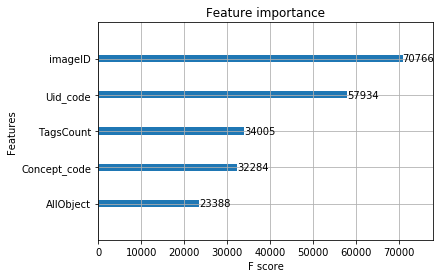

In [32]:
plot_importance(model)
plt.show()